In [26]:
import igraph as ig
import numpy as np
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import normalized_mutual_info_score as NMI
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    part = self.community_multilevel(weights=W)
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    part.W = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part.CSI = 1-2*np.sum([min(1-i,i) for i in part.W])/len(part.W)
    return part

ig.Graph.community_ecg = community_ecg


def readGraph(fn, directed=False):
    g = ig.Graph.Read_Ncol(fn+'.edgelist',directed=directed)
    c = np.loadtxt(fn+'.community',dtype='uint8')
    node_base = min([int(x['name']) for x in g.vs]) ## graphs have 1-based or 0-based nodes 
    comm_base = min(c) ## same for communities
    comm = [c[int(x['name'])-node_base]-comm_base for x in g.vs]
    g.vs['community'] = comm
    g.vs['shape'] = 'circle'
    pal = ig.RainbowPalette(n=max(comm)+1)
    g.vs['color'] = [pal.get(int(i)) for i in comm]
    g.vs['size'] = 10
    g.es['width'] = 1
    return g

In [27]:
def edgeLabels(g, gcomm):
    x = [(gcomm[x.tuple[0]]==gcomm[x.tuple[1]]) for x in g.es]
    return x
def AGRI(g, u, v):
    bu = edgeLabels(g, u)
    bv = edgeLabels(g, v)
    su = np.sum(bu)
    sv = np.sum(bv)
    suv = np.sum(np.array(bu)*np.array(bv))
    m = len(bu)
    return((suv-su*sv/m) / (0.5*(su+sv)- su*sv/m))
    #return suv/(0.5*(su+sv))


## Compare ECG, ML, IM over large LFR Graph

In [28]:
## read large noisy LFR graph (with mu=.48, n=8916) 
g = readGraph('Data/LFR8916/lfr8916')
g = g.simplify()

In [29]:
ec = g.community_ecg()
im = g.community_infomap()
ml = g.community_multilevel()

In [30]:
print('Adjusted RAND Index')
print('ML:',ARI(g.vs['community'],ml.membership))
print('ECG:',ARI(g.vs['community'],ec.membership))
print('IM:',ARI(g.vs['community'],im.membership))


Adjusted RAND Index
ML: 0.7668749068642857
ECG: 0.9760466416761016
IM: 0.9054222945195907


In [31]:
print('Adjusted Graph-aware RAND Index')
print('ML:',AGRI(g,g.vs['community'],ml.membership))
print('ECG:',AGRI(g,g.vs['community'],ec.membership))
print('IM:',AGRI(g,g.vs['community'],im.membership))


Adjusted Graph-aware RAND Index
ML: 0.9877412723055053


e:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


ECG: 0.9929537868482129
IM: 0.9646767124448767


In [32]:
## Number of clusters found
print('number of communities:',max(g.vs['community'])+1)
print('with ML:',max(ml.membership)+1)
print('with ECG:',max(ec.membership)+1)
print('with IM:',max(im.membership)+1)

number of communities: 70
with ML: 35
with ECG: 62
with IM: 218


In [33]:
## Real vs empirical 'noise' levels

m = g.vs['community'] 
m = ml.membership
#m = ec.membership
#m = im.membership

## compute 'mu' (prop. of external edges)
cnt = 0
for e in g.es:
    if m[e.tuple[0]] != m[e.tuple[1]]:
        cnt+=1
print('noise (mu):',cnt/g.ecount())

noise (mu): 0.4682640520818107


## Re-visit the ring of clique problem

In [34]:
import itertools
## ring of cliques igraph with n cliques of size m with e edges between contiguous cliques
def ringOfCliques(n=24, m=5, e=1):
    size = n*m
    g = ig.Graph()
    for i in range(size):
        g.add_vertex(str(i))
    ## ring of cliques
    for i in range(0, size, m):
        ## cliques    
        for j in range(i,i+m-1,1):
            for k in range(j+1,i+m,1):
                g.add_edge(str(j),str(k),type='intra')
        ## ring
        if i>0:
            ## all pairs (i,i+1..i+m-1) and (i-m,i-m+1..i-m+m-1)
            a = np.arange(i,i+m,1)
            b = np.arange(i-m,i,1)
        else:
            a = np.arange(0,m,1)
            b = np.arange(size-m,size,1)
        ## all 2-ples: pick e
        l = list(itertools.product(a,b))
        arr = np.empty(len(l), dtype='O')
        arr[:] = l
        x = np.random.choice(arr,size=e,replace=False)
        for j in x:
            g.add_edge(str(j[0]),str(j[1]),type='extra')
    return(g)



In [35]:
## number of communities: ML vs ECG vs IM
## n 5-cliques for 4 <= n <= 48
## number of linking edges from 1 to 5
N = np.arange(4,49,4) ## number of cliques
ML=[]
IM=[]
EC=[]
REP=10 ## take average over several repeats
for e in range(5): ## number of linking edges
    ML.append([])
    IM.append([])
    EC.append([])
    for n in N:
        ml=0
        im=0
        ec=0
        for ctr in range(REP):
            g = ringOfCliques(n=n, m=5, e=e+1)
            ml = ml + max(g.community_multilevel().membership)+1
            im = im + max(g.community_infomap().membership)+1
            ecg = g.community_ecg(ens_size=32)
            ec = ec + max(ecg.membership)+1
        ML[e].append(ml/REP)
        EC[e].append(ec/REP)
        IM[e].append(im/REP)


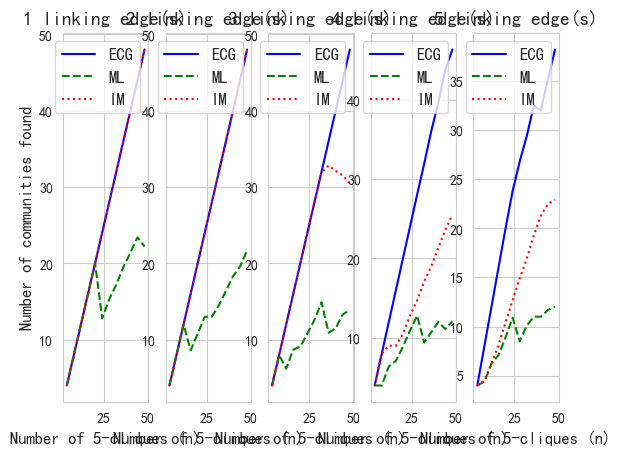

In [46]:
## Plot the results
plt.figure()
fig = plt.figure(1, figsize=(16,4))
with sns.axes_style('whitegrid'):
    for e in range(5):
        plt.subplot(1,5,e+1)
        plt.plot(N,EC[e],'-', c='b',label='ECG')
        plt.plot(N,ML[e],'--', c='g',label='ML')
        plt.plot(N,IM[e],':', c='r',label='IM')
        plt.xlabel('Number of 5-cliques (n)', fontsize=12)
        if e==0:
            plt.ylabel('Number of communities found', fontsize=12)
        plt.legend(fontsize=12)
        plt.title(str(e+1)+' linking edge(s)', fontsize=14)
plt.show()

In [37]:
## fix n=4 cliques; 
## look at ECG weights for edges internal/external to the cliques
## consider 1 to 15 edges between the cliques
## recall: 5-clique has 10 internal edges

n = 4
EXT = []  ## mean
INT = []
sEXT = [] ## stdv
sINT = []

REP=30
for xe in range(15):
    intern=[]
    extern=[]
    for ctr in range(REP):
        g = ringOfCliques(n=n, m=5, e=xe+1)
        ecg = g.community_ecg(ens_size=32)
        g.es['weight'] = ecg.W
        for e in g.es:
            if e['type'] == 'intra':
                intern.append(e['weight'])
            else:
                extern.append(e['weight'])

    INT.append(np.mean(intern))
    EXT.append(np.mean(extern))    
    sINT.append(np.std(intern))
    sEXT.append(np.std(extern))



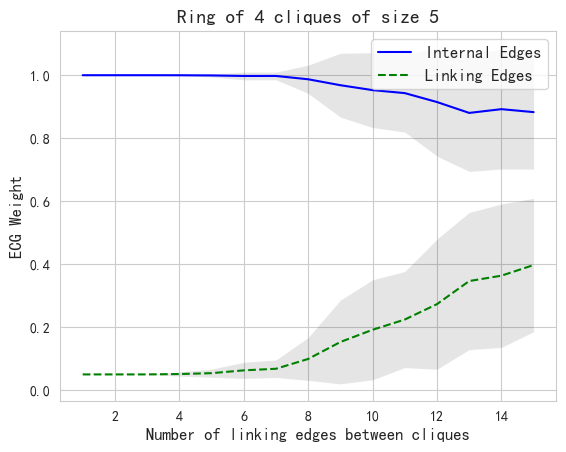

In [38]:
## Plot the results
plt.figure()
xe = np.arange(1,16,1)
fig = plt.figure(1, figsize=(7,5))
with sns.axes_style('whitegrid'):

    plt.plot(xe,INT,'-', c='b',label='Internal Edges')
    plt.fill_between(xe, [INT[i]-sINT[i] for i in range(len(INT))], 
                         [INT[i]+sINT[i] for i in range(len(INT))],
                          alpha=.1, facecolor='black')
    plt.plot(xe,EXT,'--', c='g',label='Linking Edges')
    plt.fill_between(xe, [EXT[i]-sEXT[i] for i in range(len(EXT))], 
                         [EXT[i]+sEXT[i] for i in range(len(EXT))],
                          alpha=.1, facecolor='black')
    plt.xlabel('Number of linking edges between cliques', fontsize=12)
    plt.ylabel('ECG Weight', fontsize=12)
    plt.legend(fontsize=12)
    plt.title('Ring of 4 cliques of size 5', fontsize=14)
plt.show()

In [39]:
## with 'xe' edges between cliques, plot thick edges when ECG weight > Thresh 
xe  = 15
Thresh = .8

##
size  = 5
g = ringOfCliques(n=4, m=size, e=xe)
ecg = g.community_ecg(ens_size=32)
g.es['weight'] = ecg.W
for e in g.es:
    if e['type'] == 'intra':
        intern.append(e['weight'])
    else:
        extern.append(e['weight'])
cl = np.repeat('blue',size).tolist()+np.repeat('red',size).tolist()+np.repeat('green',size).tolist()+np.repeat('cyan',size).tolist()
g.vs['color'] = cl
g.es['color'] = 'grey'
g.es['width'] = 1
for e in g.es:
    if e['weight'] >= Thresh:
        e['color'] = 'black'
        e['width'] = 2

ly = g.layout_kamada_kawai()
ig.plot(g, target='roc3.pdf', layout=ly, vertex_size=12, bbox=(0,0,400,400))


cairo.MemoryError: out of memory

## Looking at the ECG weights

CSI: 0.9339972527472528


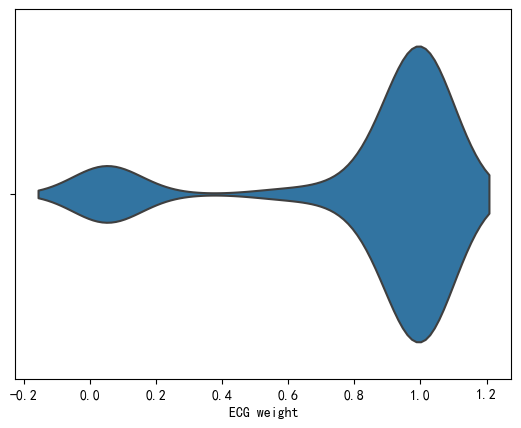

In [40]:
## Try various graphs:
plt.figure()
g = readGraph('Data/LFR15/lfr15')
#g = readGraph('Data/LFR35/lfr35')
#g = readGraph('Data/LFR55/lfr55')
#g = ig.Graph.Erdos_Renyi(n=100, m=500)

## Print CSI and plot weight distribution
ec = g.community_ecg()
print('CSI:',ec.CSI)
sns.violinplot(ec.W, inner=None)
plt.xlabel('ECG weight');
plt.show()

## Seed expansion with ECG

In [41]:
g = readGraph('Data/LFR35/lfr35')
g.vs['size'] = 10

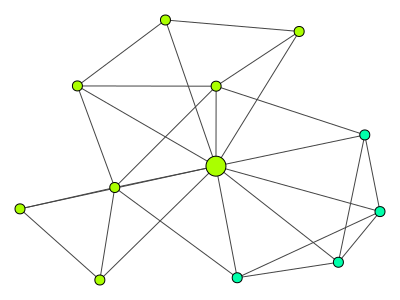

In [42]:
v = 3
Vertex = g.vs[v]['name']
g.vs[v]['size'] = 20
## ego-net
sg = g.induced_subgraph(g.neighborhood(v, order=1))
ig.plot(sg, bbox=(0,0,400,300))

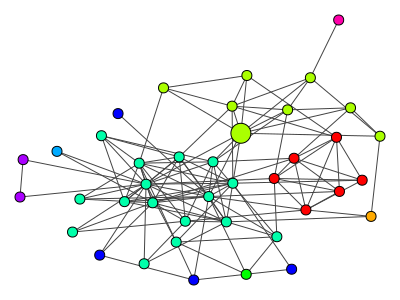

In [43]:
## 2-hops
sg = g.induced_subgraph(g.neighborhood(v, order=2))
ig.plot(sg, bbox=(0,0,400,300))

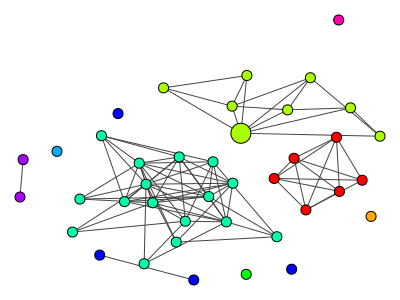

In [44]:
## Now run ECG and record edge weights
ec = g.community_ecg()
g.es['w'] = ec.W

## only show edges with high weight
Thresh = .7
g.es['width'] = 0
for e in g.es:
    if e['w'] > Thresh:
        e['width'] = 1

sg = g.induced_subgraph(g.neighborhood(v, order=2))
ig.plot(sg, bbox=(0,0,400,300))

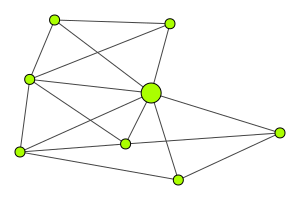

In [45]:
## keep only edges above threshold and connected component with seed
ed = [e for e in sg.es if e['w'] < Thresh]
sg.delete_edges(ed)

## keep connected component with vertex v
sg.vs['cc'] = sg.clusters().membership
v = sg.vs.find(name = Vertex)
cc = v['cc']
vd = [x for x in sg.vs if x['cc'] != cc]
sg.delete_vertices(vd)

## Plot
ig.plot(sg, bbox=(0,0,300,200))